# Project on Image Analysis using Random Forest

In [1]:
#Ignoring warnings about few features being depreciated
import warnings
warnings.filterwarnings("ignore")

#Import packages
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread, imshow

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\abhis\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Creating dataset from images
#Dictionary for loading images

fruit_img = {}

for i in range(1,81):
    fruit_img["fruit_off{}".format(i)]=0

#Load images and grayscale them

for i in range(1,81):
    fruit_img['fruit_off{}'.format(i)] = imread('./images/{}.png'.format(i), as_grey = True)
    
#Resize the images to 70x100

fruit_res = {}

for i in range(1,81):
    fruit_res['fruit{}'.format(i)] = resize(fruit_img['fruit_off{}'.format(i)],(120,150))

#Reshape the data into a 1-d array

fruit_data = {}

for i in range(1,81):
    fruit_data['fruit1d_{}'.format(i)] = np.reshape(fruit_res['fruit{}'.format(i)], (120*150))

#Stacking individual image data and images into a single multi-dimensional array

fruit_d_stack = np.stack((fruit_data.values()), axis = 0)
fruit_stack = np.stack((fruit_res.values()), axis = 0)
target = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                   2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3])
target_names = np.array(['Banana','Pineapple','Kiwi','Apple'])

#Image dataset with empty fields
fruits = {'data':0, 'images':0, 'target':0, 'target_names':0}


#Loading data and image arrays into image-dataset
fruits['data'] = fruit_d_stack
fruits['images'] = fruit_stack
fruits['target'] = target
fruits['target_names'] = target_names

len(fruits)

4

In [3]:
#Simple train test split
Xtrain,Xtest, ytrain, ytest =train_test_split(fruits['data'], fruits['target'], stratify = fruits['target'],test_size=0.3,random_state=0)

In [4]:
#Using Principle Component Analysis
pca=PCA(svd_solver='randomized',n_components=15,whiten=True,random_state=0)

In [5]:
#Using Random Forest Model with max_depth = 6
rc=RandomForestClassifier(max_depth=6,random_state=0,n_estimators=4)
model_rc=make_pipeline(pca,rc)
#Fitting the model to train data
model_rc.fit(Xtrain, ytrain);
#Predicting on test set
y_test_hat=model_rc.predict(Xtest)

In [7]:
#Accuracy for out-sample and in-sample data
acc_out=accuracy_score(ytest,y_test_hat)*100
print("Out-of-sample Accuracy: ", acc_out)
y_pred_train=model_rc.predict(Xtrain)
acc_in= accuracy_score(ytrain,y_pred_train)*100
print("In-sample Accuracy: ", acc_in)
print(classification_report(ytest, y_test_hat, target_names=fruits['target_names']))

Out-of-sample Accuracy:  41.66666666666667
In-sample Accuracy:  96.42857142857143
             precision    recall  f1-score   support

     Banana       0.43      0.50      0.46         6
  Pineapple       0.40      0.33      0.36         6
       Kiwi       0.29      0.33      0.31         6
      Apple       0.60      0.50      0.55         6

avg / total       0.43      0.42      0.42        24



In [8]:
#Plotting multiclass ROC
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


X = fruits['data']
y = fruits['target']
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify = y, random_state=0)

#Using OneVsRest Classifier and getting probability for each class
classifier = OneVsRestClassifier(model_rc)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

#fpr[i], tpr[i], _ = roc_curve(y_test[:, 0], y_score[:, 0])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


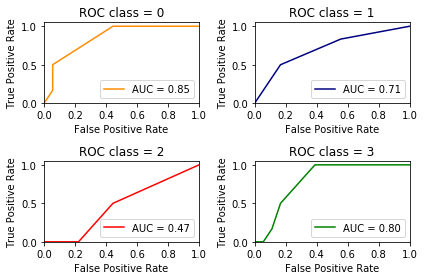

In [9]:
#Plotting ROC and printing AUC values
plt.figure()

#Plotting ROC for class 0
plt.subplot(221)
plt.plot(fpr[0], tpr[0], color='darkorange', label='AUC = %0.2f' % roc_auc[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC class = 0')
plt.legend(loc="lower right")

#Plotting ROC for class 1
plt.subplot(222)
plt.plot(fpr[1], tpr[1], color='navy', label='AUC = %0.2f' % roc_auc[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC class = 1')
plt.legend(loc="lower right")

#Plotting ROC for class 2
plt.subplot(223)
plt.plot(fpr[2], tpr[2], color='red', label='AUC = %0.2f' % roc_auc[2])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC class = 2')
plt.legend(loc="lower right")

#Plotting ROC for class 3
plt.subplot(224)
plt.plot(fpr[3], tpr[3], color='green', label='AUC = %0.2f' % roc_auc[3])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC class = 3')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [11]:
#Using Stratified K_Fold cross validation
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
accuracy_rc = cross_val_score(model_rc, fruits['data'], fruits['target'], cv=cv, scoring='accuracy')

print("Cross Validation Scores for Random Forest: {}".format(accuracy_rc))
print("Mean Accuracy Score for Random Forest: {}".format(np.mean(accuracy_rc)))
print("As we can see, the accuracy changed from {} without Stratified CV to a mean accuracy of {} when using Stratified CV with a max accuracy of {}".format(acc_out,np.mean(accuracy_rc),max(accuracy_rc)))

Cross Validation Scores for Random Forest: [0.375  0.5625 0.6875 0.3125 0.5   ]
Mean Accuracy Score for Random Forest: 0.4875
As we can see, the accuracy changed from 41.66666666666667 without Stratified CV to a mean accuracy of 0.4875 when using Stratified CV with a max accuracy of 0.6875


In [12]:
#Grid Search with Cross Validation:
param_grid_rc = {'randomforestclassifier__max_depth': [5,6,7,9],'randomforestclassifier__n_estimators': [4,5,7,9],'pca__n_components': [7,12,15,20] }
grid = GridSearchCV(model_rc, param_grid_rc, cv = 5, scoring='accuracy')
grid.fit(Xtrain, ytrain)
print(grid.best_params_)

{'pca__n_components': 15, 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__n_estimators': 9}


In [13]:
#Applying best model on data
bestModel = grid.best_estimator_
y_train_hat = bestModel.predict(Xtrain)
y_test_hat = bestModel.predict(Xtest)

In [14]:
#Checking the accuracy
in_sample_acc = accuracy_score(ytrain,y_train_hat, normalize = True) * 100
out_of_sample_acc = accuracy_score(ytest,y_test_hat, normalize = True) * 100
print("In-sample Accuracy: ", in_sample_acc)
print("Out-of-sample Accuracy: ", out_of_sample_acc)

print(classification_report(ytest, y_test_hat, target_names=fruits['target_names']))

In-sample Accuracy:  98.21428571428571
Out-of-sample Accuracy:  45.83333333333333
             precision    recall  f1-score   support

     Banana       0.38      0.50      0.43         6
  Pineapple       0.60      0.50      0.55         6
       Kiwi       0.40      0.33      0.36         6
      Apple       0.50      0.50      0.50         6

avg / total       0.47      0.46      0.46        24



In [15]:
#Plotting multiclass ROC with best parameters
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


X = fruits['data']
y = fruits['target']
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify = y, random_state=0)
pca=PCA(svd_solver='randomized',n_components=15,whiten=True,random_state=0)
rc=RandomForestClassifier(max_depth=9,random_state=0,n_estimators=9)
model_rc_roc =make_pipeline(pca,rc)

#Using OneVsRest Classifier and getting probability for each class
classifier = OneVsRestClassifier(model_rc_roc)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

#fpr[i], tpr[i], _ = roc_curve(y_test[:, 0], y_score[:, 0])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


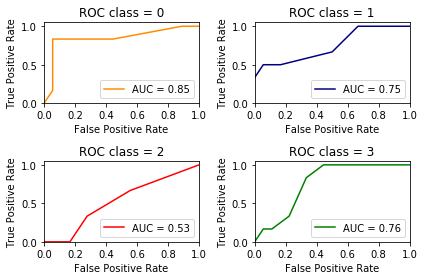

In [16]:
#Plotting ROC and printing AUC values
plt.figure()

#Plotting ROC for class 0
plt.subplot(221)
plt.plot(fpr[0], tpr[0], color='darkorange', label='AUC = %0.2f' % roc_auc[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC class = 0')
plt.legend(loc="lower right")

#Plotting ROC for class 1
plt.subplot(222)
plt.plot(fpr[1], tpr[1], color='navy', label='AUC = %0.2f' % roc_auc[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC class = 1')
plt.legend(loc="lower right")

#Plotting ROC for class 2
plt.subplot(223)
plt.plot(fpr[2], tpr[2], color='red', label='AUC = %0.2f' % roc_auc[2])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC class = 2')
plt.legend(loc="lower right")

#Plotting ROC for class 3
plt.subplot(224)
plt.plot(fpr[3], tpr[3], color='green', label='AUC = %0.2f' % roc_auc[3])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC class = 3')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()